## Выявление закономерностей, определяющих успешность компьютерных игр.
> В данной работе мы будем работать с датасетом о продажах игр для разных платформах. На дворе декабрь 2016 года и нам требуется путём анализа, предположить, какие жанры и платформы будут популярны в грядущем 2017 году

### Шаг 1. Откроем файл с данными и изучим общую информацию <a name="s1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)
import seaborn as sns
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
from scipy import stats as st
from scipy.stats import levene
pd.set_option('chained_assignment', None)
pd.set_option('display.max_columns', None)

data = pd.read_csv('/datasets/games.csv')
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<BarContainer object of 25 artists>

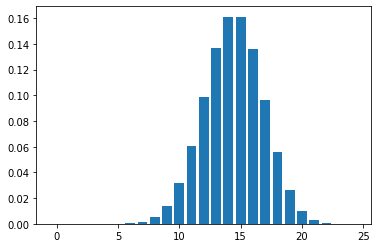

In [2]:
from matplotlib import pyplot as plt
from math import factorial

n = 24
p = 0.6

distr = []

for k in range(0,n+1):
        choose = factorial(n)/(factorial(k) * factorial(n-k))
        prob = choose * p**k * (1-p)**(n-k) 
        distr.append(prob)

plt.bar(range(0,n+1), distr) 

Вывод: датасет имеет следующие колонки:
 - **Name** — название игры
 - **Platform** — платформа
 - **Year_of_Release** — год выпуска
 - **Genre** — жанр игры
 - **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
 - **EU_sales** — продажи в Европе (миллионы проданных копий)
 - **JP_sales** — продажи в Японии (миллионы проданных копий)
 - **Other_sales** — продажи в других странах (миллионы проданных копий)
 - **Critic_Score** — оценка критиков (максимум 100)
 - **User_Score** — оценка пользователей (максимум 10)
 - **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. Например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».<br>
***
*Вывод:* Имеются пропуски в следующих колонках:  *Name, Year_of_Release, Critic_Score, User_Score* и *Rating* - мое предположение, что если в колонках *Name* и *Year_of_Release* - пропуски случайны (человеческий фактор при составлении БД), то в колонках *Critic_Score, User_Score* и *Rating* - значения в принципе отсутствуют, т.к. игры не оценены <br>
Заполнить эти пропуски мы не можем, т.к. это индивидуальные данные по каждому конкретному случаю

### Шаг 2. Подготовим данные <a name="s2"></a>

> Заменим названия столбцов (приведем к нижнему регистру)

In [2]:
data.columns = data.columns.str.lower()

> Преобразуем данные в нужные типы. Обработаем пропуски при необходимости:

In [3]:
data.dropna(subset = ['name'],inplace = True)
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year

*Вывод:* Удалил 2 строчки без указания названия игры. Столбец 'year_of_release' (год выпуска) привел к типу "дата", оставив только год <br>
***
Пропуски есть в столбцах:
 - *year_of_release* (год релиза) - заменить nan не можем, т.к. не можем додумать значения, если потребуется сможем вообще удалить строчки с пропусками - их 1,6% от общего количества)<br>
 - *critic_score* (оценка критиков) - заменить nan не можем, т.к. не можем додумать значения<br>
 - *user_score* (оценка пользователей) - заменить nan не можем, т.к. не можем додумать значения<br>
 - *rating* (рейтинг/возрастная категория) - заменить nan не можем, т.к. не можем додумать значения
 ***

> Отдельно разберем значение 'tbd' в столбцах с рейтингом и опишем, как его обработать;

In [4]:
#Выведем строки tbd
display(data.query('user_score=="tbd"').head())
#tbd - to be determined, то есть "будет определено", соответственно на данный момент значение равноценно nan
#столбец приведем к типу float64, с заменой "ошибок"(tbd) на nan
data['user_score'] = pd.to_numeric(data['user_score'],errors = 'coerce')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


> Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [5]:
data['world_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

### Шаг 3. Проведем исследовательский анализ данных <a name="s3"></a>

 > Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

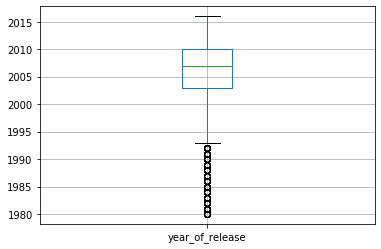

In [6]:
data.boxplot(column = 'year_of_release')
plt.show()
data.query('year_of_release >=1993', inplace = True)

*Вывод:* по результатам построения boxplot стало очевидно, что ранее 1993 года игр выпускалось настолько мало, что эти данные можно отбросить, они не повлияют на результат исследования

 > Посмотрим, как менялись продажи по платформам. 

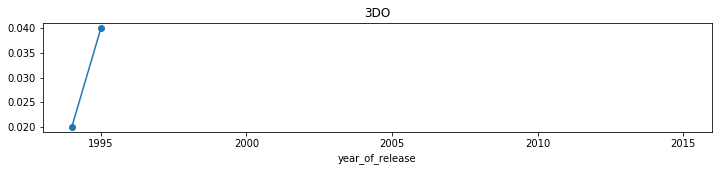

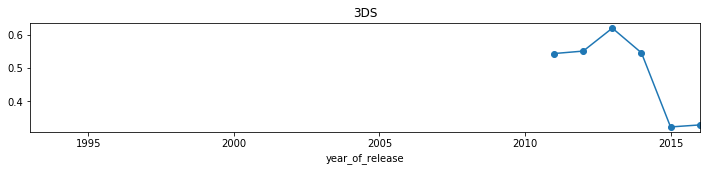

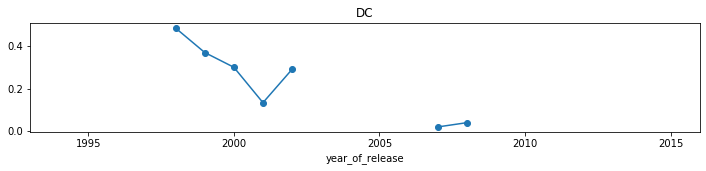

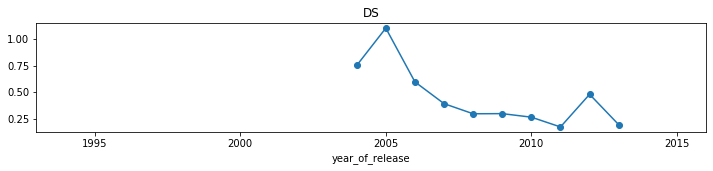

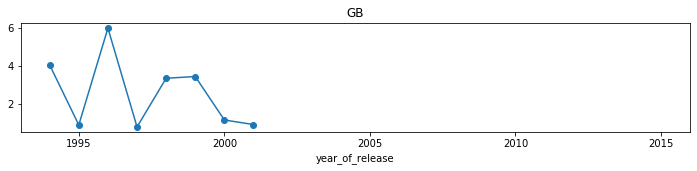

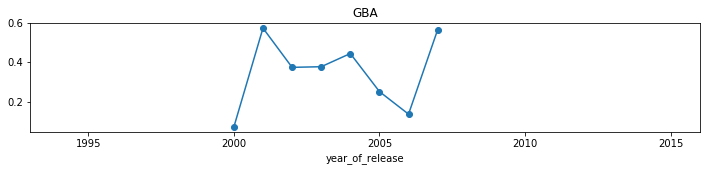

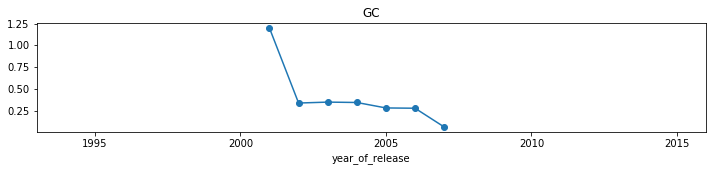

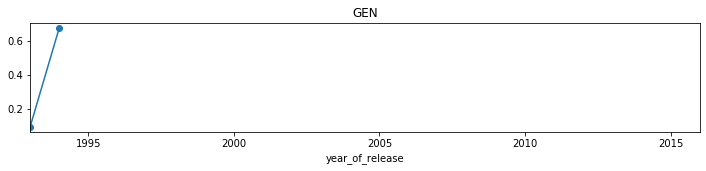

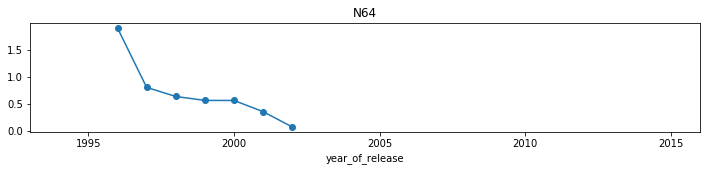

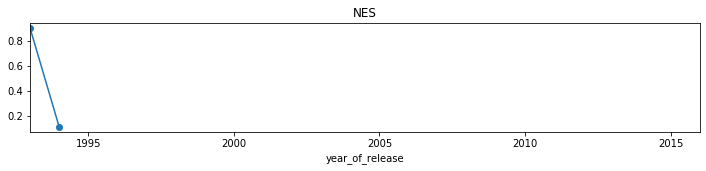

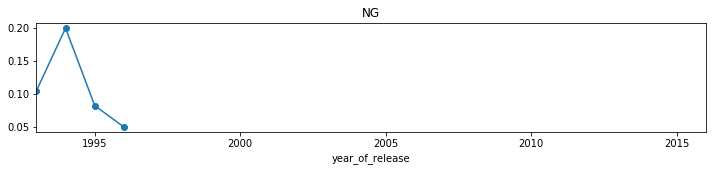

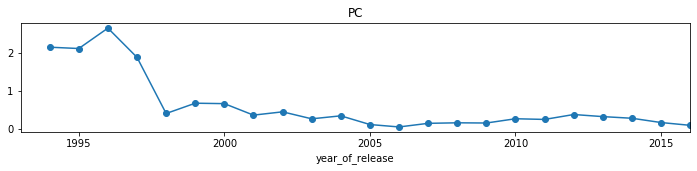

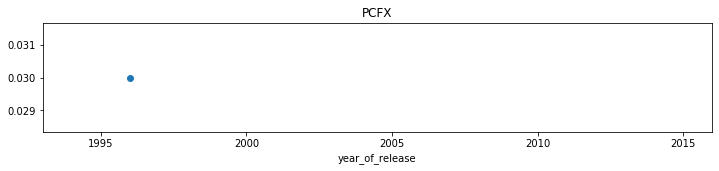

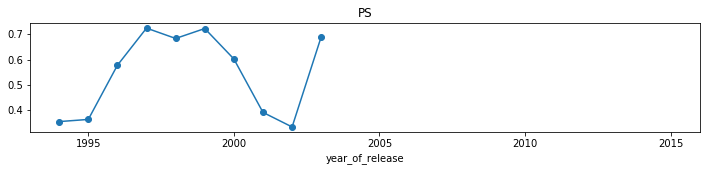

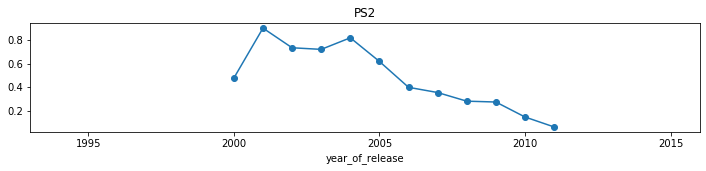

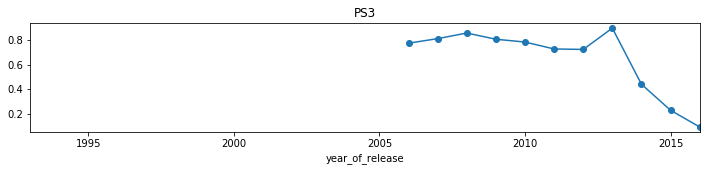

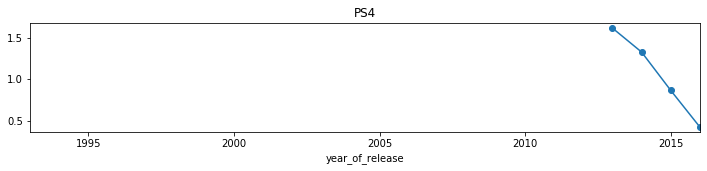

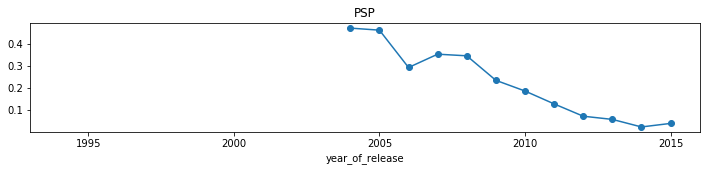

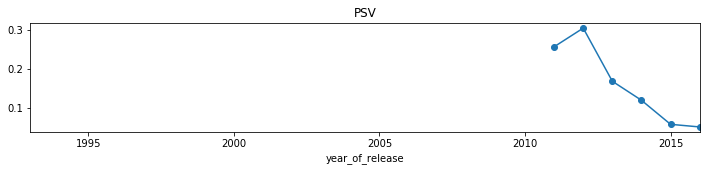

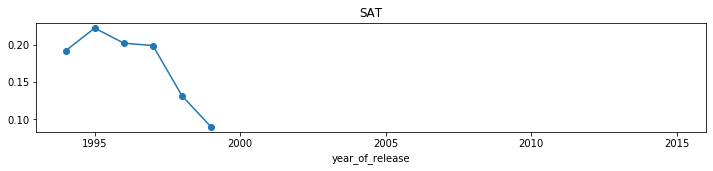

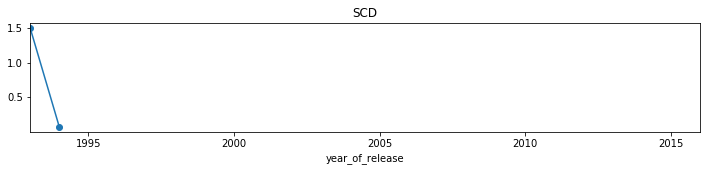

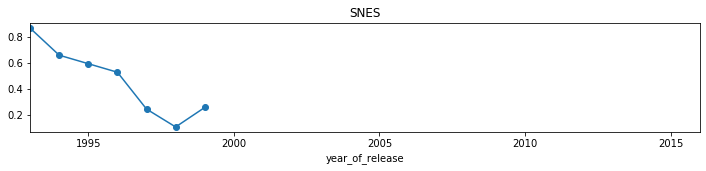

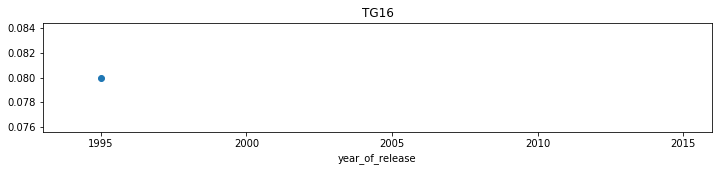

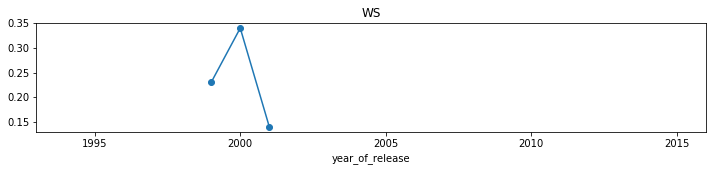

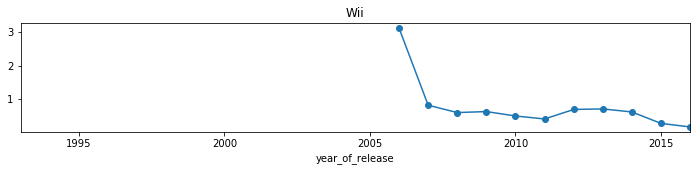

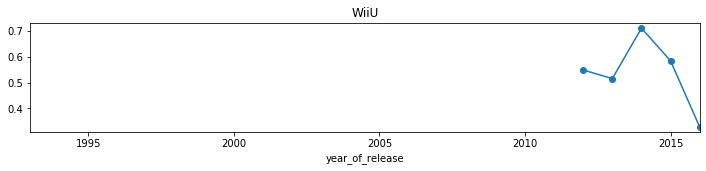

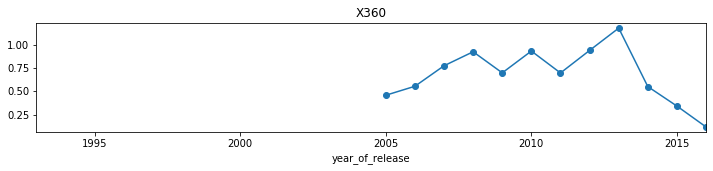

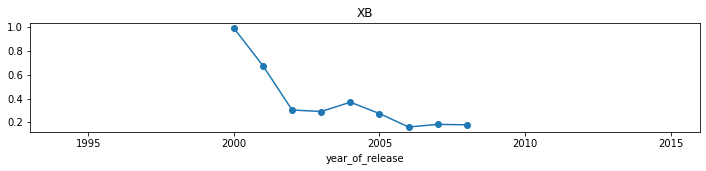

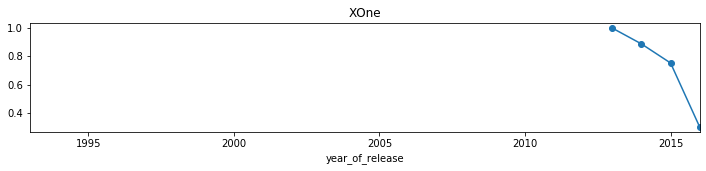

In [7]:
platform_game_sales = data.pivot_table(index = 'platform',columns = 'year_of_release', values = 'world_sales')

for x in platform_game_sales.index:
    plt.figure(figsize=(12, 2))
    platform_game_sales.loc[x].plot(title = x, style = '-o')

 > Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

,world_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


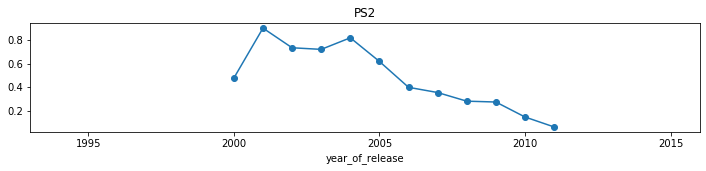

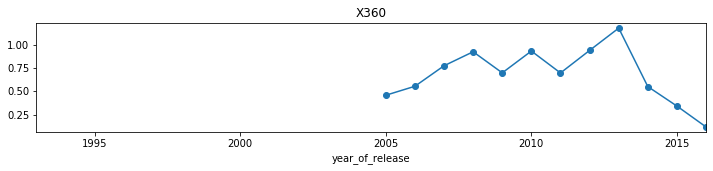

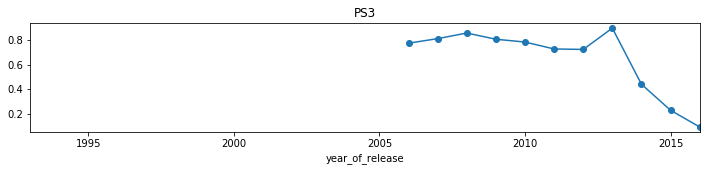

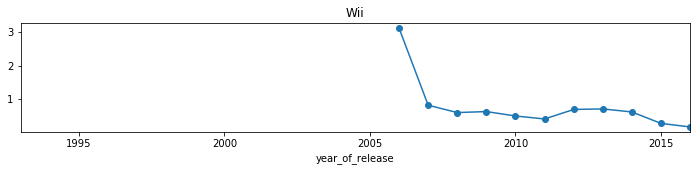

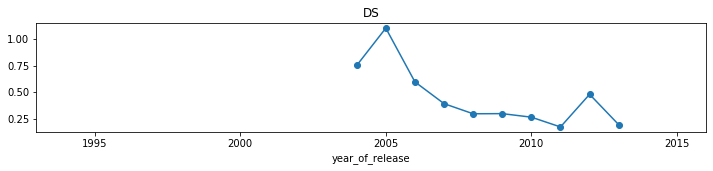

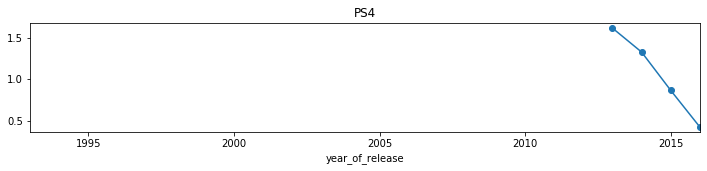

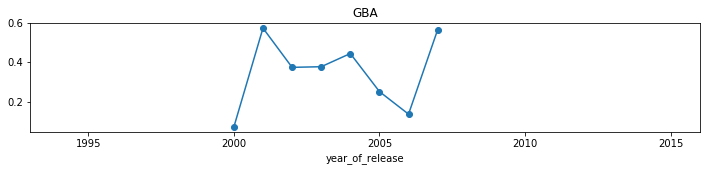

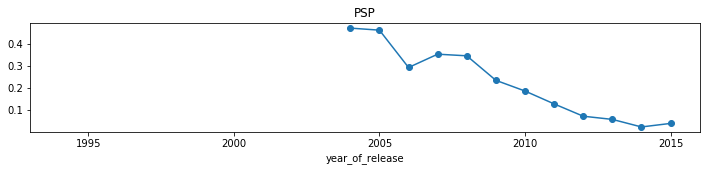

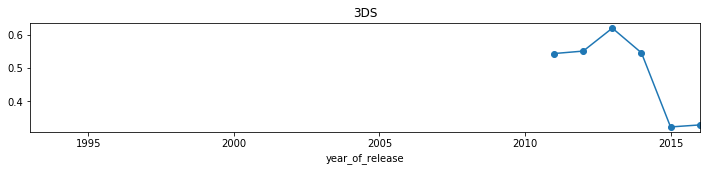

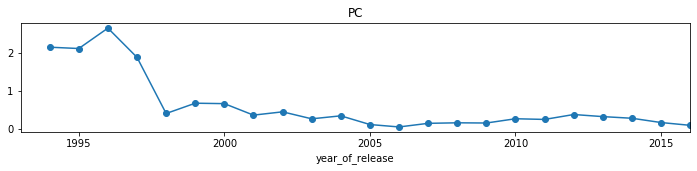

In [8]:
platform_game_sales_sum = data.pivot_table(index = 'platform', values = 'world_sales', aggfunc = 'sum')
display(platform_game_sales_sum.sort_values(by = ['world_sales'], ascending = False).head(11))
top_platform = [ 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS4', 'GBA', 'PSP', '3DS', 'PC']
for xx in top_platform:
    plt.figure(figsize=(12, 2))
    platform_game_sales.loc[xx].plot(title = xx, style = '-o')

> Посмотрим медианное число лет существования платформы

In [9]:
print('медианное время жизни консолей (все консоли с 1993 года):', platform_game_sales.count(axis = 1).median())

top_platforms_game_sales = platform_game_sales.query('platform ==@top_platform')
print('медианное время жизни консолей (топ-11 консолей с 1993 года):',top_platforms_game_sales.count(axis = 1).median())

медианное время жизни консолей (все консоли с 1993 года): 7.0
медианное время жизни консолей (топ-11 консолей с 1993 года): 11.0


*Вывод:*  Судя по гистограммам можно сделать вывод что среднее время "жизни" консоли - примерно 10 лет. Это не относится к персональному компьютеру. 
***
***Вывод 2:*** Судя по медианному значению нашей таблички - получил уточнение, что среднее время жизни любой платформы 7 лет, среднее время  жизни топовых (популярных) платформ - 11 лет

 > Оставим в нашей таблице данные с консолями, вышедшими не далее 8 лет назад (2008)на основании предыдущего вывода - судя по всему эти консоли "проживут" еще 2 года на рынке, соответственно в 2017 году будут ещё актуальны.Таких всего 6: 3ds, ps4, psv, wiiu, xone и pc. Год ограничим 2013

In [10]:
#таблица, от которой теперь будем отталкибаться(с отсеянными лишними платформами и годами)
current_platform = data.query('year_of_release >=2013 and platform == ("3DS","PS4","PSV","WiiU","XOne","PC")')

 > Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

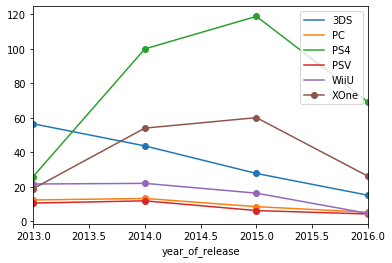

In [11]:
current_platform_sort = current_platform.pivot_table(index = 'platform',columns = 'year_of_release', values = 'world_sales', aggfunc = 'sum')

for xxx in current_platform_sort.index:
    current_platform_sort.loc[xxx].plot(legend  = xxx, style = '-o')

*Вывод:* для периода 2015-2016 продажи по всем платформам падают (по условию задачи у нас декабрь 2016 года, но, возможно мы получили не все данные за период 2016 года. Топ-3 перспективных платформы для разработки игр это 3DS, PS4 и XOne

 > Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.

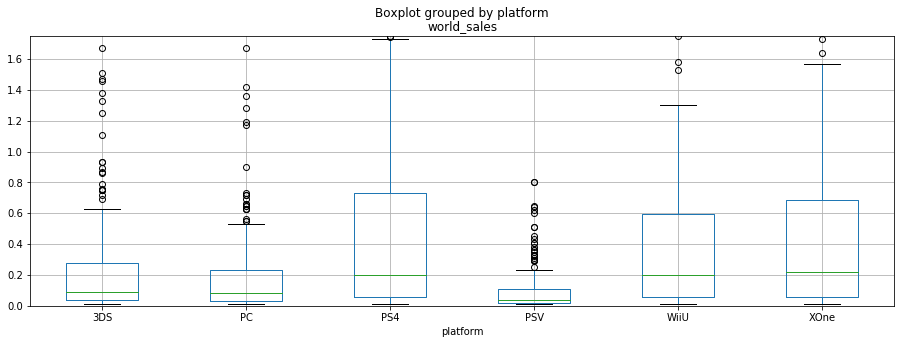

In [12]:
#display(current_platform.pivot_table(index = "platform",values = 'world_sales',aggfunc = 'count'))
current_platform.boxplot(column=['world_sales'], by='platform',figsize =(15,5))
plt.ylim(0,1.75)
plt.show()   

*Вывод:* Среди актуальных платформ "стабильные" средние показатели продаж игр у платформы PS4, на 2м месте XOne (у нее чуть меньше стабильное среднее количество продаж игр, но зато чуть больше медианная значений), на 3м меcте WiiU (ещё меньше значение продаж, но медианная на уровне XOne), остальные платформы отстают от первой троицы с отрывом.

 > Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.

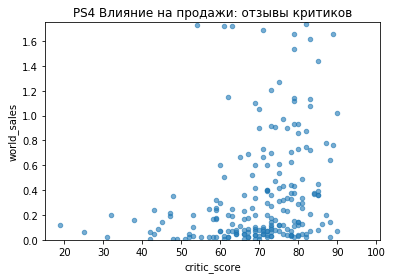

PS4 корреляция к продажам: отзывы критиков:  0.40656790206178095



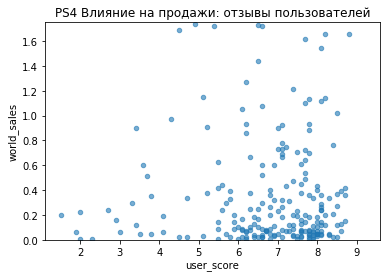

PS4 корреляция к продажам: отзывы пользователей:  -0.031957110204556424


In [13]:
ps4 = current_platform.query('platform =="PS4"')
ps4.plot(y='world_sales',x='critic_score',kind='scatter',ylim = (0,1.75),alpha = 0.6,title="PS4 Влияние на продажи: отзывы критиков")
plt.show()
print('PS4 корреляция к продажам: отзывы критиков: ', ps4['critic_score'].corr(ps4['world_sales']))
print()

ps4.plot(y='world_sales',x='user_score',kind='scatter',ylim = (0,1.75),alpha = 0.6,title="PS4 Влияние на продажи: отзывы пользователей")
plt.show()
print('PS4 корреляция к продажам: отзывы пользователей: ', ps4['user_score'].corr(ps4['world_sales']))

*Вывод:* прямая корреляция от продаж прослеживается с отзывами критиков, с отзывами пользователей всё не так однозначно

 > Соотнесем выводы с продажами игр на других платформах.

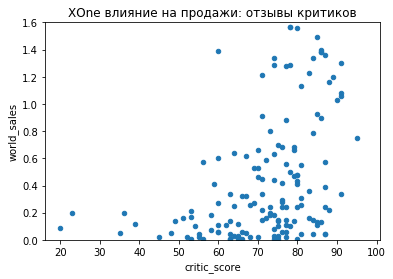

XOne корреляция к продажам: отзывы критиков:  0.4169983280084017



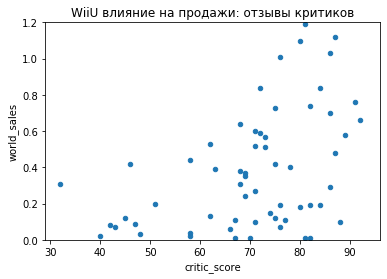

WiiU корреляция к продажам: отзывы критиков:  0.3764149065423912


In [14]:
x_one = current_platform.query('platform =="XOne"')
x_one.plot(y='world_sales',x='critic_score',kind='scatter',ylim = (0,1.6),title="XOne влияние на продажи: отзывы критиков")
plt.show()
print('XOne корреляция к продажам: отзывы критиков: ', x_one['critic_score'].corr(x_one['world_sales']))
print()

wii_u = current_platform.query('platform =="WiiU"')
wii_u.plot(y='world_sales',x='critic_score',kind='scatter',ylim = (0,1.2),title="WiiU влияние на продажи: отзывы критиков")
plt.show()
print('WiiU корреляция к продажам: отзывы критиков: ', wii_u['critic_score'].corr(wii_u['world_sales']))

*Вывод:* аналогично полученному результату на PS4, на платформах WiiU и XOne прослеживается взаимосвязи продаж и оценок критиков (корреляция около 0,4) 

 > Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [15]:
genre_rating = current_platform.pivot_table(index ='genre', values ='world_sales', aggfunc = ['sum', 'mean'])
genre_rating.columns = ['sum', 'mean']
display(genre_rating.sort_values(by=['sum'],ascending=False))

,sum,mean
genre,,
Action,199.18,0.350669
Shooter,165.71,1.358279
Role-Playing,123.94,0.543596
Sports,90.67,0.713937
Misc,34.66,0.309464
Platform,34.22,0.622182
Racing,30.36,0.506000
Fighting,26.69,0.556042
Simulation,19.81,0.396200


*Вывод:* Самые продающиеся жанры - активные (шутер, экшн и ролевые игры), в конце рейтинга - паззлы, адвенчур и стратегии, в сумме прибыли (и в среднем) они приносят в 10 раз меньше дохода для платформ

### Шаг 4. Составим портрет пользователя каждого региона <a name="s4"></a>
#### Определим для пользователя каждого региона (NA, EU, JP):

> Самые популярные платформы (топ-5). Опишем различия в долях продаж.

топ-5 платформ по продажам в северной америке


,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


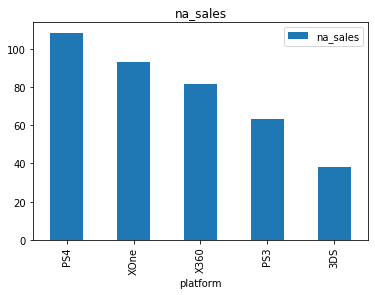

топ-5 платформ по продажам в европе


,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


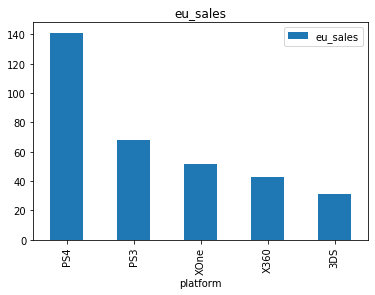

топ-5 платформ по продажам в японии


,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


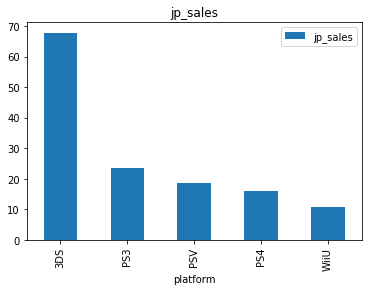

In [16]:
#Для того, чтобы не упустить какую-либо платформу(а ранее мы начали работать с усеченной таблицей 'current_platform'),
#вернемся к нашей "большой" начальной таблице 'data'
na_preferences = data.query('year_of_release >=2013').pivot_table(index ='platform', values ='na_sales', aggfunc = 'sum')
print('топ-5 платформ по продажам в северной америке')
display(na_preferences.sort_values(by = ['na_sales'],ascending=False).head())
na_preferences.sort_values(by = ['na_sales'],ascending=False).head().plot(kind = 'bar', subplots=True)
plt.show()

eu_preferences = data.query('year_of_release >=2013').pivot_table(index ='platform', values ='eu_sales', aggfunc = 'sum')
print('топ-5 платформ по продажам в европе')
display(eu_preferences.sort_values(by = ['eu_sales'],ascending=False).head())
eu_preferences.sort_values(by = ['eu_sales'],ascending=False).head().plot(kind = 'bar', subplots=True)
plt.show()

jp_preferences = data.query('year_of_release >=2013').pivot_table(index ='platform', values ='jp_sales', aggfunc = 'sum')
print('топ-5 платформ по продажам в японии')
display(jp_preferences.sort_values(by = ['jp_sales'],ascending=False).head())
jp_preferences.sort_values(by = ['jp_sales'],ascending=False).head().plot(kind = 'bar', subplots=True)
plt.show()

*Вывод:* 
 - Для северной америки и европы ситуации с распределением по консолям примерно одинаковое ( на первых местах Х360 и PS3, далее Wii), далее с отрывом следуют PS4, PC и DS <br>
 - А вот в японии распределение между 5 платформами +- одинаковое, с заметным отличием только в платформе 3DS (которой на остальных рынках даже в топ-5 не вошла)

> Самые популярные жанры (топ-5). Поясним разницу.

топ-5 жанров по продажам в северной америке


,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


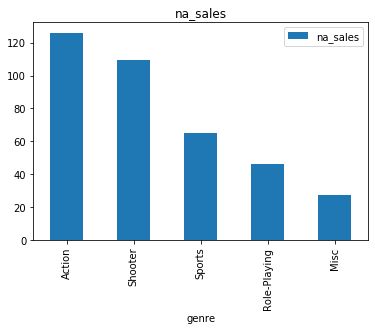

топ-5 жанров по продажам в европе


,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


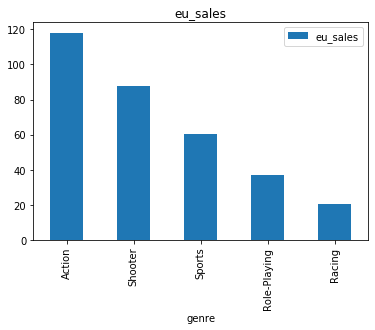

топ-5 жанров по продажам в японии


,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


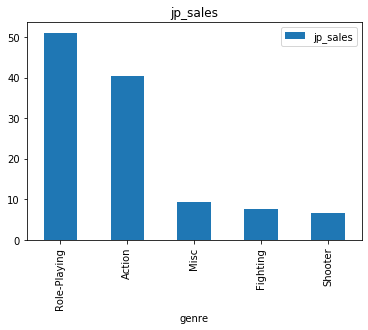

In [17]:
na_genres = data.query('year_of_release >=2013').pivot_table(index ='genre', values ='na_sales', aggfunc = 'sum')
print('топ-5 жанров по продажам в северной америке')
display(na_genres.sort_values(by = ['na_sales'],ascending=False).head())
na_genres.sort_values(by = ['na_sales'],ascending=False).head().plot(kind = 'bar', subplots=True)
plt.show()

eu_genres = data.query('year_of_release >=2013').pivot_table(index ='genre', values ='eu_sales', aggfunc = 'sum')
print('топ-5 жанров по продажам в европе')
display(eu_genres.sort_values(by = ['eu_sales'],ascending=False).head())
eu_genres.sort_values(by = ['eu_sales'],ascending=False).head().plot(kind = 'bar', subplots=True)
plt.show()

jp_genres = data.query('year_of_release >=2013').pivot_table(index ='genre', values ='jp_sales', aggfunc = 'sum')
print('топ-5 жанров по продажам в японии')
display(jp_genres.sort_values(by = ['jp_sales'],ascending=False).head())
jp_genres.sort_values(by = ['jp_sales'],ascending=False).head().plot(kind = 'bar', subplots=True)
plt.show()

*Вывод:* 
 - по жанрам игры в северной америке и европе распределились практически идентично! Шутеры и экшн , потом спорт, делее ролевые игры и "остальное". 
 - япония отличилась как по платформам, так и в части жанров:  -тут с большим отрывом идёт жанр ролевых игр и экшн)



> Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [18]:
current_platform['rating'].fillna('rating not defined', inplace = True)
print('Рейтинг игр и продажи в серверной америке')
display(current_platform.pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum').sort_values(by = ['na_sales']))
print()
print('Рейтинг игр и продажи в европе')
display(current_platform.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum').sort_values(by = ['eu_sales']))
print()
print('Рейтинг игр и продажи в японии')
display(current_platform.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum').sort_values(by = ['jp_sales']))

Рейтинг игр и продажи в серверной америке


,na_sales
rating,
E10+,32.25
T,35.07
E,52.37
rating not defined,68.68
M,97.05



Рейтинг игр и продажи в европе


,eu_sales
rating,
E10+,26.30
T,32.60
E,58.00
rating not defined,63.54
M,94.51



Рейтинг игр и продажи в японии


,jp_sales
rating,
E10+,5.66
M,8.17
E,13.26
T,13.52
rating not defined,72.97


*Вывод:* Несмотря на то, что из представленных категорий рейтинга, "М" (mature) самый жесткий, и для продаж игр с таким рейтингом наверняка накладываются некоторые ограничения, продажи игр "М" обходят остальные игры. - это относится к европе и северной америке. <br>
Япония отличается - на самые продаваемые игры рейтинг не определен


### Шаг 5. Проверим гипотезы <a name="s5"></a>

> Проверим гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
>> пороговое значение альфа зададим как 0.05 (для нашей задачи это вполне нормально, меньшее значение имело бы смысл задавать при необходимости особой точности (медицинские исследования и т.п.) <br>
>> для указания параметра equal_var проверим равенство дисперсий выборок, для понимания, каким тестом это проверять (тест Левена или тест Бартлета) - предварительно проверим нормальность распределения выборок тестом Шапиро-Уилка

In [19]:
x_one_user_score = x_one['user_score'].dropna()
pc_user_score = current_platform.query('platform =="PC"').user_score.dropna()

#Проверим нормальность распределения выборок Xbox One и PC тестом Шапиро-Уилка
stat_x_one,pvalue_x_one = st.shapiro(x_one_user_score)
stat_pc,pvalue_pc = st.shapiro(pc_user_score)
alpha = .05

if pvalue_x_one > alpha:
    print('данные в выборке Xbox One распределены нормально (тест Шапиро-Уилка)')
else:
    print('данные в выборке Xbox One распределены не нормально (тест Шапиро-Уилка)')

if pvalue_pc > alpha:
    print('данные в выборке PC распределены нормально (тест Шапиро-Уилка)')
else:
    print('данные в выборке PC распределены не нормально (тест Шапиро-Уилка)')    
print()

#Видим что обе выборки распределены не нормально, используем тест Левена для оценки равенства дисперсий
alpha = .05
stat, pval = st.levene(x_one_user_score, pc_user_score)
if pval > alpha:
    print('дисперсия выборок Xbox One и PC - равна (тест Левена)')
else:
    print('дисперсия выборок Xbox One и PC - не равна (тест Левена)')    
print()

#Зная, что дисперсии равны, вписываем параметр equal_var
alpha = .05
results = st.ttest_ind(x_one_user_score, pc_user_score, equal_var = True)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу (cредние пользовательские рейтинги платформ Xbox One и PC одинаковые), значение pvalue приэтом: ", results.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу (cредние пользовательские рейтинги платформ Xbox One и PC одинаковые), значение pvalue приэтом: ", results.pvalue) 

данные в выборке Xbox One распределены не нормально (тест Шапиро-Уилка)
данные в выборке PC распределены не нормально (тест Шапиро-Уилка)

дисперсия выборок Xbox One и PC - не равна (тест Левена)

Не получилось отвергнуть нулевую гипотезу (cредние пользовательские рейтинги платформ Xbox One и PC одинаковые), значение pvalue приэтом:  0.14012658403611647


**Вывод:** В нашем случае нулевая гипотеза о 2х сравниваемых выборках Xbox One и PC звучала так: Средние пользовательские рейтинги платформ одинаковые. Альтернативная гипотеза звучала так: средние пользовательские рейтинги платформ разные <br>
По результатам т-теста мы делаем вывод, о том что **cредние пользовательские рейтинги платформ Xbox One и PC одинаковые**

***
> Проверим гипотезу: средние пользовательские рейтинги жанров Action (экшен-игры) и Sports (англ. «спортивные соревнования») разные
>> для подготовки сравниваемых выборок проделаем предварительные действия, аналогичные предыддущему шагу

In [20]:
action = current_platform.query('genre =="Action"').user_score.dropna()
sports = current_platform.query('genre =="Sports"').user_score.dropna()

#Проверим нормальность распределения выборок Action и Sports тестом Шапиро-Уилка
stat_action,pvalue_action = st.shapiro(action)
stat_sports,pvalue_sports = st.shapiro(sports)
alpha = .05

if pvalue_action > alpha:
    print('данные в выборке Action распределены нормально (тест Шапиро-Уилка)')
else:
    print('данные в выборке Action распределены не нормально (тест Шапиро-Уилка)')

if stat_sports > alpha:
    print('данные в выборке Sports распределены нормально (тест Шапиро-Уилка)')
else:
    print('данные в выборке Sports распределены не нормально (тест Шапиро-Уилка)')    
print()

#Так как в одной из наших выборок данные распределены не нормально, используем тест Левена для оценки равенства дисперсий
alpha = .05
stat, pval = st.levene(action, sports)
if pval > alpha:
    print('дисперсия выборок Action и Sports - равна (тест Левена)')
else:
    print('дисперсия выборок Action и Sports - не равна (тест Левена)')    
print()

#Зная, что дисперсии не равны, вписываем параметр equal_var
alpha = .05
results = st.ttest_ind(action, sports, equal_var = False)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу (cредние пользовательские рейтинги жанров Action и Sports одинаковые), значение pvalue приэтом: ", results.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу (cредние пользовательские рейтинги жанров Action и Sports одинаковые), значение pvalue приэтом: ", results.pvalue) 

данные в выборке Action распределены не нормально (тест Шапиро-Уилка)
данные в выборке Sports распределены нормально (тест Шапиро-Уилка)

дисперсия выборок Action и Sports - не равна (тест Левена)

Отвергаем нулевую гипотезу (cредние пользовательские рейтинги жанров Action и Sports одинаковые), значение pvalue приэтом:  1.2678091455806196e-11


**Вывод:** В нашем случае нулевая гипотеза о 2х сравниваемых выборках в жанрах Action и Sports звучала так: Средние пользовательские рейтинги жанров одинаковые. Альтернативная гипотеза звучала так: средние пользовательские рейтинги жанров- разные <br>
По результатам т-теста мы делаем вывод, о том что **cредние пользовательские рейтинги жанров Action и Sports - отличаются**

### Шаг 6. Напишем общий вывод <a name="s6"></a>

По результатам исследования нашего датафреймы, мы можем сделать следующие выводы:
 - 1) ранее 1993 года игр выпускалось настолько значительно меньше, чем после
 - 2) среднее время "жизни" консоли - примерно 10 лет. Исключение - РС (т.к. РС используется не только как игровая консоль)
 - 3) среди актуальных платформ "стабильные" средние показатели продаж игр у платформы PS4, на 2м месте XOne (у нее чуть меньше стабильное среднее количество продаж игр, но зато чуть больше медианная значений), на 3м мете WiiU (ещё меньше значение продаж, но медианная на уровне XOne), остальные платформы отстают от первой троицы с отрывом.
 - 4) на топ-3 платформах (PS4, Wii и Xbox) прямая корреляция от продаж прослеживается с отзывами критиков, с отзывами пользователей всё не так однозначно 
 - 5) cамые продающиеся жанры - активные (шутер, экшн и ролевые игры), в конце рейтинга - паззлы, адвенчур и стратегии, в сумме прибыли (и в среднем) они приносят в 10 раз меньше дохода для платформ
 - 6) распределение по продажам игр на платформы для северной америки и европы примерно одинаковое (на первых местах Х360 и PS3, далее Wii), далее с отрывом следуют PS4, PC и DS,а вот в японии распределение между 5 платформами +- одинаковое, с заметным отличием только в платформе 3DS (которой на остальных рынках даже в топ-5 не вошла)
 - 7) по жанрам игры в северной америке и европе распределились практически идентично. Шутеры и экшн , потом спорт, делее ролевые игры и "остальное", япония отличилась как по платформам, так и в части жанров: -тут с большим отрывом идёт жанр ролевых игр, далее экшн, спорт, адвенчур и "остальное".)
 - 8) несмотря на то, что из представленных категорий рейтинга, "М" (mature) самый жесткий, и для продаж игр с таким рейтингом наверняка накладываются некоторые ограничения, продажи игр "М" обходят остальные игры.
 - 9) cредние пользовательские рейтинги платформ Xbox One и PC одинаковые, cредние пользовательские рейтинги жанров Action и Sports - отличаются
 
 > Рекомендации на 2017 год <br>
 Если мы планируем рекламные компании на будущий год, то следует обратить внимание на игры:
    - выходящие в европе и америке на платформах PS4,  в жанре экшн (мнение критиков о выходящей игре также иметь ввиду)
    - выходящие в японии - игра на платформе 3DS, в жанре ролевая игра (мнение критиков о выходящей игре также иметь ввиду)